# Take-home exam 2: notebook

Bifurcations maps were done in CEDIA because of RAM constraints. See `Code` in the root directory.

In [2]:
# Libraries
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import scienceplots

# Plot style
plt.style.use(['science', 'nature', 'high-vis'])

### 4. Given the piecewise map:
$$
x_{n+1} = f(x_n) = \begin{cases}
(1+ \epsilon)x_n + x_n^2, & \text{if } x_n < x^* \\
1-x_n, & \text{if } x_n > x^*,
\end{cases}
$$
### compute the Lyapunov exponent for $\epsilon \in [-0.4, 0.4]$ and $x_0 \in [0, 1]$.

**Note:** $x^*$ is the solution of $(1+ \epsilon)x_n + x_n^2 = 1.$

In [2]:
# Define the symbols
x = sp.symbols('x')

In [3]:
# Calculate the function values
def solve(eps):
    
    # Define the equation
    eq = (1 + eps)*x + x**2 - 1

    # Solve the equation
    sol = sp.solve(eq, x)

    # Filter only in the range [0, 1]
    sol = [s.evalf() for s in sol if 0 <= s.evalf() <= 1]

    return np.array(sol)[0]

In [4]:
# Array of eps
eps = np.linspace(-0.4, 0.4, 100)

# Call the function
sol = np.array([solve(e) for e in eps])

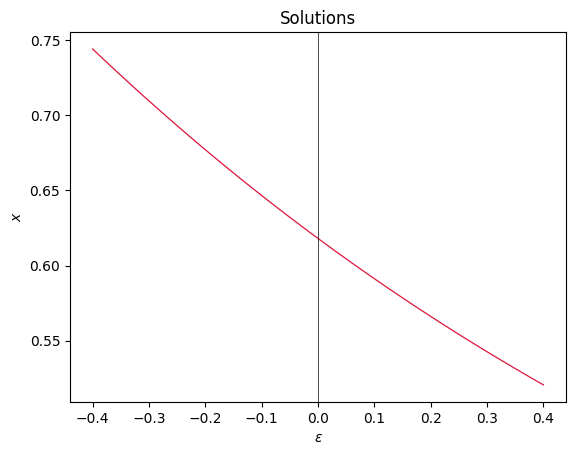

In [15]:
# Plot the results
plt.figure()
plt.plot(eps, sol, lw = 0.9, c = 'crimson')
plt.title('Solutions')
plt.xlabel(r"$\epsilon$")
plt.ylabel(r"$x$")
plt.axvline(0, color='black', lw=0.5)
plt.show()

In [5]:
# Map
def piecewise_map(x, eps, x_star):
    if x < x_star:
        return (1 + eps)*x + x**2
    else:
        return 1 - x
    
# Derivative
def derivative(x, eps, x_star):
    if x < x_star:
        return 1 + eps + 2*x
    else:
        return -1

In [6]:
# Lyapunov exponent
def lyapunov(r_min = 1.0, 
             r_max = 4.0, 
             partitions = 1000,
             transient = 1000, 
             nontransient = 9000, 
             initial_x = 0.20,
             map: callable = piecewise_map,
             derivative_map: callable = derivative):
    
    # Values for r
    r_values = np.linspace(r_min, r_max, partitions)

    # Initialize Lyapunov exponent
    log_list = np.zeros(nontransient)
    lyapunov_r = np.zeros(partitions)

    # Calculate the x_star values
    x_star_values = np.array([solve(r) for r in r_values])
    
    print("---------------------------------------------------")
    print("Calculating the Lyapunov exp...")
    print("---------------------------------------------------")

    # For each parameter value
    for i, r in enumerate(r_values):
        
        # Initial condition
        x = initial_x

        # Determine x_star
        x_star = x_star_values[i]
        
        # Run transient iterations
        for _ in range(transient):
            x = map(x, r, x_star)
            
        # print(f"Transient iterations done!")
        
        # Record iterations after transient
        for _ in range(nontransient):

            # Get the next value
            x = map(x, r, x_star)

            # Compute the derivative
            deriv = derivative_map(x, r, x_star)

            # Log of it
            log = np.log(abs(deriv) + 1e-10)

            # Append to the list
            log_list[_] = log

        # Compute the Lyapunov exponent
        lyapunov_r[i] = np.mean(log_list)

    print("Done!")
    print("---------------------------------------------------")

    return lyapunov_r, r_values

In [7]:
# Call it
lyapunov_eps, eps_values = lyapunov(r_min = -0.4, 
                                r_max = 0.4, 
                                partitions = 100,
                                transient = 2000, 
                                nontransient = 1000, 
                                initial_x = 0.20,
                                map = piecewise_map,
                                derivative_map = derivative)

---------------------------------------------------
Calculating the Lyapunov exp...
---------------------------------------------------
Done!
---------------------------------------------------


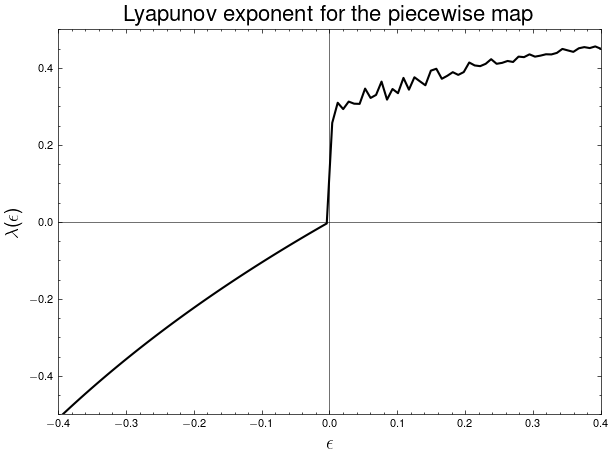

In [22]:
# Plot the results
plt.figure(figsize=(7, 5))
plt.plot(eps_values, lyapunov_eps, lw = 1.5, c = "k")
plt.title('Lyapunov exponent for the piecewise map', fontsize=16)
plt.ylabel(r"$\lambda(\epsilon)$", fontsize=14)
plt.xlabel(r"$\epsilon$", fontsize=14)
plt.axhline(0, color='black', lw=0.4)
plt.axvline(0, color='black', lw=0.4)
# Make ticks smaller
plt.tick_params(axis='both', which='major', labelsize=8)
plt.savefig('./plots/piecewise_lya.pdf', dpi=300, bbox_inches='tight')
plt.xlim(-0.4, 0.4)
plt.ylim(-0.5, 0.5)
plt.show()

### 5. Given the map:
$$
x_{n+1} = f(x_n) = \frac{1-b^{x_n(1-x_n)}}{1-b^{1/4}}
$$
### compute the Lyapunov exponent for $b \in [0, 1]$ and $x_0 \in [0, 1]$.

In [3]:
# Map
def frac_map(x, b):
    num = 1 - b**(x * (1 - x))
    den = 1 - b**(1/4) 
    return num/den

# Derivative
def frac_derivative(x, b):
    num = (1 - 2 * x) * b**(x*(1-x)) * np.log(b)
    den = - (1 - b**(1/4))
    return num/den

In [4]:
# Lyapunov exponent
def lyapunov(r_min = 1.0, 
             r_max = 4.0, 
             partitions = 1000,
             transient = 1000, 
             nontransient = 9000, 
             initial_x = 0.20,
             map: callable = frac_map,
             derivative_map: callable = frac_derivative):
    
    # Values for r
    r_values = np.linspace(r_min, r_max, partitions)

    # Initialize Lyapunov exponent
    log_list = np.zeros(nontransient)
    lyapunov_r = np.zeros(partitions)
    
    print("---------------------------------------------------")
    print("Calculating the Lyapunov exp...")
    print("---------------------------------------------------")

    # For each parameter value
    for i, r in enumerate(r_values):
        
        # Initial condition
        x = initial_x
        
        # Run transient iterations
        for _ in range(transient):
            x = map(x, r)
            
        # print(f"Transient iterations done!")
        
        # Record iterations after transient
        for _ in range(nontransient):

            # Get the next value
            x = map(x, r)

            # Compute the derivative
            deriv = derivative_map(x, r)

            # Log of it
            log = np.log(abs(deriv) + 1e-10)

            # Append to the list
            log_list[_] = log

        # Compute the Lyapunov exponent
        lyapunov_r[i] = np.mean(log_list)

    print("Done!")
    print("---------------------------------------------------")

    return lyapunov_r, r_values

In [8]:
# Call it
lyapunov_b, b_values = lyapunov(r_min = 0.001, 
                                r_max = 0.999, 
                                partitions = 1000,
                                transient = 2000, 
                                nontransient = 1000, 
                                initial_x = 0.22,
                                map = frac_map,
                                derivative_map = frac_derivative)

---------------------------------------------------
Calculating the Lyapunov exp...
---------------------------------------------------
Done!
---------------------------------------------------


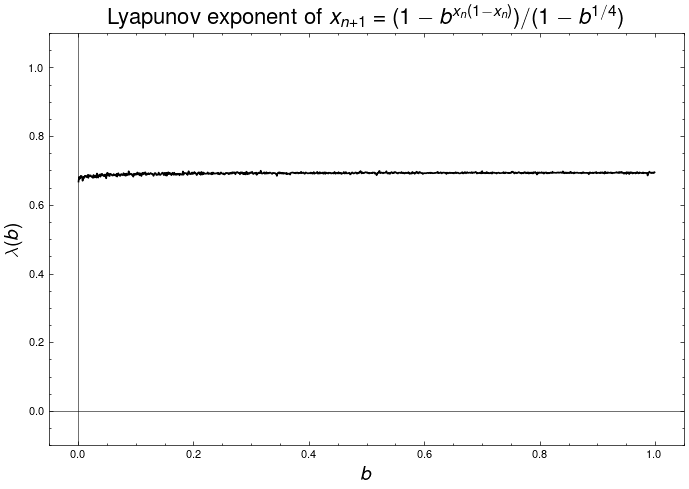

In [15]:
# Plot the results
plt.figure(figsize=(7, 5))
plt.plot(b_values, lyapunov_b, lw = 1.2, c = "k")
plt.title('Lyapunov exponent of ' + r"$x_{n+1}=(1-b^{x_n(1-x_n)})/(1-b^{1/4})$", fontsize=16)
plt.ylabel(r"$\lambda(b)$", fontsize=14)
plt.xlabel(r"$b$", fontsize=14)
plt.axhline(0, color='black', lw=0.4)
plt.axvline(0, color='black', lw=0.4)
# Make ticks smaller
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tight_layout()
plt.xlim(-0.05, 1.05)
plt.ylim(-0.1, 1.1)
plt.savefig('./plots/frac_lya.pdf', dpi=300, bbox_inches='tight')
plt.show()

### Is the map unimodal?

In [5]:
# x values
x_values = np.linspace(0, 1, 1000)

# B values
b_values = np.linspace(0.001, 0.1, 50)

# List for y values
y_list = []

# Get the map for each b
for b in b_values:
    
    # Get the map
    y_values = frac_map(x_values, b)
    
    # Plot it
    y_list.append(y_values)

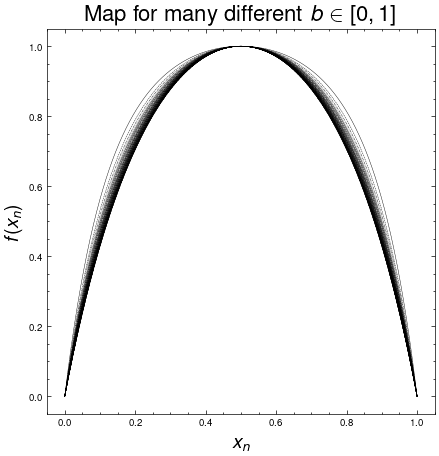

In [77]:
# Plot the results
plt.figure(figsize=(5, 5))
for i, b in enumerate(b_values):
    plt.plot(x_values, y_list[i], lw = 0.3, c = "k", alpha = 1)
plt.title('Map for many different $b \in [0, 1]$', fontsize=16)
plt.ylabel(r"$f(x_n)$", fontsize=14)
plt.xlabel(r"$x_n$", fontsize=14)
#plt.axhline(0, color='black', lw=0.5)
#plt.axvline(0, color='black', lw=0.5)
plt.show()

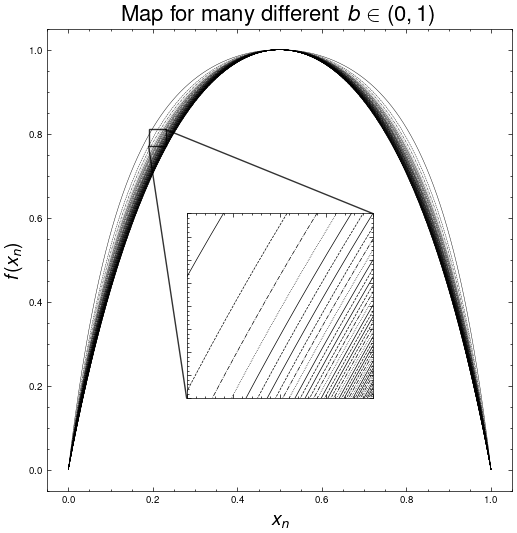

In [6]:
# Plot the results
fig, ax = plt.subplots(figsize=(6, 6)) # Get fig and ax objects

for i, b in enumerate(b_values):
    ax.plot(x_values, y_list[i], lw=0.3, c="k", alpha=1)

ax.set_title('Map for many different $b \\in (0, 1)$', fontsize=16)
ax.set_ylabel(r"$f(x_n)$", fontsize=14)
ax.set_xlabel(r"$x_n$", fontsize=14)
ax.set_xlim(-0.05, 1.05) # Set limits for main plot
ax.set_ylim(-0.05, 1.05) # Set limits for main plot

# --- Create Inset Axes ---
# Define the position and size of the inset axes: [left, bottom, width, height] in fractions of the main axes
axins = ax.inset_axes([0.30, 0.20, 0.4, 0.4])  # [left, bottom, width, height]

# Plot the same data on the inset axes
for i, b in enumerate(b_values):
    axins.plot(x_values, y_list[i], lw=0.5, c="k", alpha=1)

# --- Define the Zoom Region ---
x1, x2 = 0.2-0.01, 0.2+0.03  # X limits for zoom
y1, y2 = 0.8-0.03, 0.8+0.01  # Y limits for zoom
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# Hide tick labels for the inset axes if desired
axins.set_xticklabels('')
axins.set_yticklabels('')

# --- Indicate the Zoom Area ---
# Draw a box indicating the region of the inset plot
ax.indicate_inset_zoom(axins, edgecolor="black", alpha=0.8, lw=1.0) 

plt.savefig('./plots/unimodal.pdf', dpi=300, bbox_inches='tight')

plt.show()
# ... rest of the cell ...